# packages used

In [1]:
# misc
%matplotlib inline

from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# DATA - prep
#kaggle
import pandas as pd
import sklearn.model_selection

from collections import Counter
import re



# ML - models 
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import xgboost.sklearn

# ML - accuracy
import sklearn.metrics

# ML - visualize model
import shap


# Get data

In [2]:
getdata = False

Setup:
- follow "API credential step" listed here: https://github.com/Kaggle/kaggle-api
    - go to https://www.kaggle.com/ (login)
    - go to my_profile (download kaggle.json)
    - put it in ~/.kaggle/kaggle.json
    - `cp ~/Downloads/kaggle.json ~/.kaggle/kaggle.json`
    - `chmod 600 ~/.kaggle/kaggle.json`
- Go to kaggle and join competition: 
    - https://www.kaggle.com/c/titanic
- install kaggle
- download data
- profit!!!

In [3]:
# !pip install kaggle -q
# -q is just for quite, so we don't spam the notebook

In [4]:

metadata = {
    'basepath' : '../data/',
    'dataset':'titanic',
    'train' : 'train.csv',
    'test' : 'test.csv'}


In [5]:
# make folder
# download .zip
# unzip
# remove the .zip
# (data is placed ../data/titanic)
if getdata:
    !mkdir -p {metadata['basepath']}
    !kaggle competitions download -c dataset {metadata['dataset']} -p {metadata['basepath']}
    !unzip -o {metadata['basepath']}{metadata['dataset']}.zip -d {metadata['basepath']}{metadata['dataset']}/
    !rm {metadata['basepath']}{metadata['dataset']}.zip

# Load and explore

In [6]:
# load
train = pd.read_csv("{basepath}/{dataset}/{train}".format(**metadata))
test = pd.read_csv("{basepath}/{dataset}/{test}".format(**metadata))


In [7]:
# Train
display(HTML("<h1>train</h1>"))
# example data
display(train.head(3))
# summary stats
display(train.describe())
# list missing values
display(pd.DataFrame(train.isna().mean() ,columns=["is na fraction"]))
# list types of column
display(train.dtypes)
# list dimenstion
display(train.shape)


# TODO check test

display(HTML("<h1>test</h1>"))
display(pd.DataFrame(test.isna().mean() ,columns=["is na fraction"]))


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,is na fraction
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

(891, 12)

,is na fraction
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.205742
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.002392
Cabin,0.782297


In [8]:
# clean data / build feature 
# to_expand

target = "Survived"
# keep numeric features without missing vals
keep_features = ["Pclass","SibSp","Parch"]

y = train[target]
X = train.drop(target,axis=1)

In [9]:
# Split data in train and validation
target = "Survived"

seed = 42
test_size = 0.7

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X,
    y,
    random_state = seed,
    test_size = test_size)


# Clean

In [10]:
train.iloc[20:30,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S


## Manual exploration - nlp cols

In [11]:
def nlp_df(df,col):
    return pd.DataFrame({
    "text" : df[col].fillna('').apply(lambda x: re.sub('[^A-Z]', '', x) ) ,
    "text_parts_nbr" : df[col].fillna("")\
        .apply(lambda x: len(re.sub('[^A-Z ]', '', x).split(" ")) if x!="" else 0        
              ).astype("int32") ,
    "text_start" : df[col].fillna('').apply(lambda x: re.sub('[^A-Z ]', '', x).split(" ")[0]) ,
    "numeric_end" : df[col].fillna('')\
        .apply(lambda x: re.sub('[^0-9 ]', '', x)\
        .split(" ")[-1]).replace("","-1").astype("int32")
    })


def nlp_frequent(df,col,n = 10):
    df2 = df.groupby(col).size().sort_values(axis=0,ascending=False).reset_index()
    df2.head(n).plot.bar(x = col, y = 0)
    return df2

### Ticket

Text(0.5, 1.0, 'Ticket')

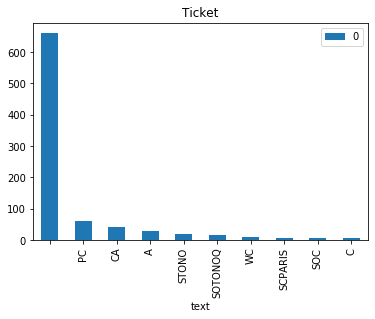

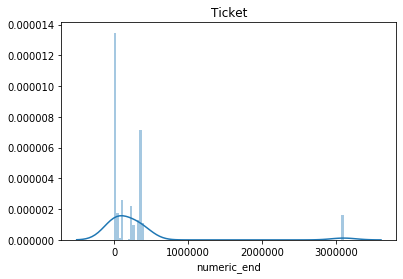

In [12]:
col = "Ticket"
tmp_ticket = nlp_df(df=train, col=col)
tmp_ticket_summary = nlp_frequent(df=tmp_ticket,col="text")
plt.title(col)

plt.figure(2)
display(sns.distplot(tmp_ticket["numeric_end"],100))
plt.title(col)

### names

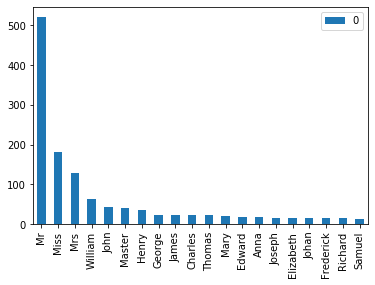

In [13]:
names_clean = train["Name"].apply(lambda x: re.sub('[^a-zA-Z ]', '', x).split(" "))
all_names = [i for j in names_clean.values for i in j]

letter_counts = Counter(all_names)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.sort_values(by=0, axis=0, ascending=False,inplace=True)

#df.head(20)
df.head(20).plot(kind='bar')

### Cabin

Text(0.5, 1.0, 'Cabin')

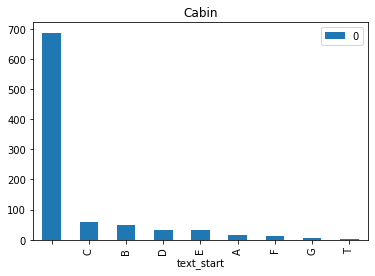

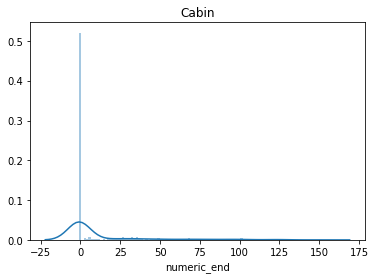

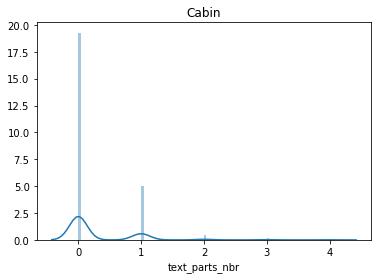

In [14]:
col = "Cabin"
tmp_ticket = nlp_df(df=train, col=col)
tmp_ticket_summary = nlp_frequent(df=tmp_ticket,col="text_start")
plt.title(col)

plt.figure(2)
display(sns.distplot(tmp_ticket["numeric_end"],100))
plt.title(col)

plt.figure(3)
display(sns.distplot(tmp_ticket["text_parts_nbr"],100))
plt.title(col)

##  automatic

### helper functions

In [15]:
def ds_explore(df_src,target,cols_rm,**kwargs):
    unique_lim = kwargs.get("unique_lim",50)
    target=[target]
    
    cols_num = [i for i in df_src._get_numeric_data().columns if i not in cols_rm + target]
    cols_str = [i for i in df_src.columns if i not in cols_num + cols_rm + target]

    unique_count = df_src[cols_str].nunique()
    

    cols_str_cat = list(unique_count[unique_count<unique_lim].index)
    cols_str_nlp = [i for i in cols_str if i not in cols_str_cat]

    meta = {
        "cols_str_cat" : cols_str_cat
        ,"cols_str_nlp" : cols_str_nlp
        ,"cols_num" : cols_num
        ,"target" : target
    }
    # we now have split the dataset in 3 categories
    # num_cols = numeric columns
    # str_cat = string columns that can be treated as categorical
    # str_nlp = string columns that can be treated as nlp

    return meta


def get_column_names_from_ColumnTransformer(column_transformer): 
    # Primarly:
    # https://github.com/scikit-learn/scikit-learn/issues/12525
    # Secodary:
    # https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline):
            # missing chaining all transformers just pick the last?
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [16]:

# Auto categorize columns
cols_rm = ["PassengerId"]

meta = ds_explore(df_src=train
           ,target = target
           ,cols_rm = cols_rm)

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer


meta["trans_num"] = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

meta["trans_str_cat"] = Pipeline(steps=[
    #('imputer', SimpleImputer(missing_values=[None,float('nan')],strategy='constant', fill_value='missing')),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', meta["trans_num"], meta["cols_num"]),
        ('cat', meta["trans_str_cat"], meta["cols_str_cat"])
    ])

preprocessor.fit(X_train.copy())

meta["new_cols"] = get_column_names_from_ColumnTransformer(preprocessor)

X_train_clean = pd.DataFrame(preprocessor.transform(X_train.copy()),columns=meta["new_cols"])
X_val_clean = pd.DataFrame(preprocessor.transform(X_val.copy()), columns=meta["new_cols"])
test_clean = pd.DataFrame(preprocessor.transform(test.copy()), columns=meta["new_cols"])

# ML

In [20]:


# default models
# Logistic regression 
model_logreg = sklearn.linear_model.LogisticRegression()
model_logreg.fit(X_train_clean, y_train);

# decision tree
model_decision_tree = sklearn.tree.DecisionTreeClassifier()
model_decision_tree.fit(X_train_clean, y_train);

# randomForest
model_random_forest = sklearn.ensemble.RandomForestClassifier()
model_random_forest.fit(X_train_clean, y_train);

# xgboost
model_xgboost = xgboost.sklearn.XGBClassifier()
model_xgboost.fit(X_train_clean, y_train);



Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


# Eval ML

In [21]:
# naive model
class naive_model():
    # everyone dies
    def predict(self, df):
        return np.zeros(df.shape[0])

model_naive = naive_model()

preprocessor.transform(X_val.copy())

models = {
    "model_naive" : model_naive,
    "model_logreg" : model_logreg,
    "model_decision_tree": model_decision_tree,
    "model_random_forest": model_random_forest,
    "model_xgboost" :model_xgboost
}

for name,model in zip(models.keys(),models.values()):
    acc = sklearn.metrics.accuracy_score(
     y_true = y_val,
     y_pred = model.predict(X_val_clean)
    )

    print(name,round(acc,4))



model_naive 0.609
model_logreg 0.8013
model_decision_tree 0.7612
model_random_forest 0.7885
model_xgboost 0.8077


# explain xgboost

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


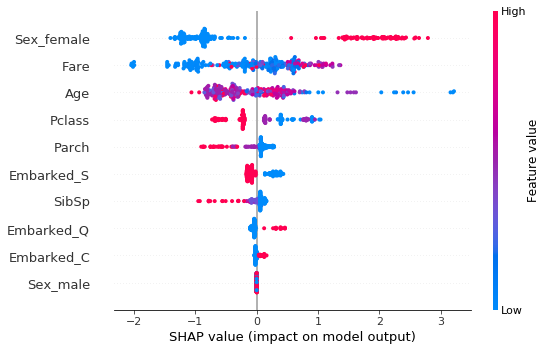

In [22]:
explainer = shap.TreeExplainer(model_xgboost)
shap_values = explainer.shap_values(X_train_clean)
shap.summary_plot(shap_values, X_train_clean)

# Output

In [25]:
# passengerid
id = "PassengerId"

out = pd.DataFrame({
    id : test[id],
    target : models["model_xgboost"].predict(
    test_clean
    )
    },dtype=np.int32)

# put them out
outfile = metadata["basepath"] + "output_xgboost_features.csv"
out.to_csv(path_or_buf = outfile,
           index = False)


In [ ]:
# Submit
#!kaggle competitions submit {metadata['dataset']} -f {outfile} -m "created_features"

In [ ]:
# See submission 
!kaggle competitions submissions "{metadata['dataset']}"